In [1]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00" # avoid memory fragmentation on JAX backend.

import keras
import keras_nlp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() # progress bar for pandas

import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, Markdown

In [3]:
class CFG:
    seed = 42
    dataset_path = "/kaggle/input/medical-chat"
    preset = "gemma_2b_en" # name of pretrained Gemma
    sequence_length = 512 # max size of input sequence for training
    batch_size = 1  # size of the input batch in training, x 2 as two GPUs
    epochs = 10 # number of epochs to train
    

In [4]:
keras.utils.set_random_seed(CFG.seed)

In [5]:
import os
print(os.listdir('/kaggle/input'))

['medical-chat', 'gemma']


In [6]:
import os
print(os.listdir(CFG.dataset_path))


['Medical.csv']


In [7]:
#df = pd.read_csv(f"{CFG.dataset_path}/Medical.csv")
#df.head(2)

# Try reading the file with the default encoding (UTF-8) and ignoring errors
try:
    # Read the CSV with UTF-8 encoding, removing invalid characters
    df = pd.read_csv(f"{CFG.dataset_path}/Medical.csv", encoding='ISO-8859-1')
    df.head(2)
except Exception as e:
    str(e)

In [8]:
df.head(2)

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...


In [9]:
df = df[-1000:].copy()


In [10]:
df.tail()

,qtype,Question,Answer
16450,Side Effects,What are the side effects of Omeprazole?,"Common side effects include headache, stomach ..."
16451,Drug Category,What pharmaceutical category does Lisinopril b...,Lisinopril is an ACE inhibitor used to treat h...
16452,Typical Usage,How is Lisinopril typically used,Lisinopril is usually taken once daily to lowe...
16453,Dosage,What is the typical dosage for Lisinopril?,The usual starting dose is 10 mg once daily fo...
16454,Side Effects,What are the side effects of Lisinopril?,"Common side effects include cough, dizziness, ..."


In [14]:
#template = "\n\nqtype:\nMedical-{qtype}\n\nQuestion:\n{Question}\n\nAnswer:\n{Answer}"

In [11]:
template = "\n\nQuestion:\n{Question}\n\nAnswer:\n{Answer}"

In [14]:
#from tqdm import tqdm
#tqdm.pandas()

# Apply the template to each row and create a new 'prompt' column
#df["prompt"] = df.progress_apply(lambda row: template.format(qtype=row.qtype,
                                                             #Question=row.Question,
                                                             #Answer=row.Answer), axis=1)
#data = df.prompt.tolist()

In [12]:
from tqdm import tqdm
tqdm.pandas()

# Apply the template to each row and create a new 'prompt' column
df["prompt"] = df.progress_apply(lambda row: template.format(
                                                             Question=row.Question,
                                                             Answer=row.Answer), axis=1)
data = df.prompt.tolist()

100%|██████████| 1000/1000 [00:00<00:00, 33572.70it/s]


In [16]:
# Function to colorize the template text
#def colorize_text(text):
   # for word, color in zip(["qtype", "Question", "Answer"], ["blue", "red", "green"]):
       # text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
   # return text

In [13]:
# Function to colorize the template text
def colorize_text(text):
    for word, color in zip(["Question", "Answer"], ["red", "green"]):
        text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [14]:

# Take a random sample (for example, the 45th entry from the 'data' list)
sample = data[45]

# Colorize the sample text (apply colors to 'qtype', 'Question', and 'Answer')
sample = colorize_text(sample)

# Display the colorized sample in markdown
display(Markdown(sample))



**<font color='red'>Question:</font>**
What are the symptoms of Cleft palate X-linked ?

**<font color='green'>Answer:</font>**
What are the signs and symptoms of Cleft palate X-linked? The Human Phenotype Ontology provides the following list of signs and symptoms for Cleft palate X-linked. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Bifid uvula - Cleft palate - X-linked inheritance - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate of the percentage of patients who have that feature. The frequency may also be listed as a fraction. The first number of the fraction is how many people had the symptom, and the second number is the total number of people who were examined in one study. For example, a frequency of 25/25 means that in a study of 25 people all patients were found to have that symptom. Because these frequencies are based on a specific study, the fractions may be different if another group of patients are examined. Sometimes, no information on frequency is available. In these cases, the sign or symptom may be rare or common.

In [15]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

In [16]:
x, y, sample_weight = gemma_lm.preprocessor(data[0:2])

In [17]:
# Display the shape of each processed output
for k, v in x.items():
    print(k, ":", v.shape)

token_ids : (2, 1024)
padding_mask : (2, 1024)


In [22]:
# Take one sample
#row = df.iloc[2]

# Generate Prompt using template
#prompt = template.format(
    #qtype=row.qtype,
    #Question=row.Question,
    #Answer=""
#)

# Infer
#output = gemma_lm.generate(prompt, max_length=256)

# Colorize
#output = colorize_text(output)

# Display in markdown
#display(Markdown(output))

In [18]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
    Question=row.Question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
What are the treatments for Cri du chat syndrome ?

**<font color='green'>Answer:</font>**
There is no cure for Cri du chat syndrome. However, there are treatments that can help manage the symptoms. These include:

- Physical therapy: This can help improve muscle tone and coordination.
- Occupational therapy: This can help improve fine motor skills and coordination.
- Speech therapy: This can help improve communication skills.
- Psychological therapy: This can help improve emotional well-being.
- Nutritional therapy: This can help improve growth and development.
- Medical therapy: This can help manage symptoms such as seizures and sleep disorders.

It is important to work with a team of healthcare professionals to develop a treatment plan that is tailored to the individual needs of the child.

**<font color='red'>Question:</font>**
What are the causes of Cri du chat syndrome ?

**<font color='green'>Answer:</font>**
The cause of Cri du chat syndrome is not fully understood. However, it is thought to be a genetic disorder that is caused by a mutation in the CHD8 gene. This gene is responsible for the production of a protein that is involved in the development of the brain and nervous system.

**<font color='red'>Question:</font>**
What are the symptoms of Cri du chat syndrome ?

**<font color='green'>Answer:</font>**
The symptoms of Cri du

In [24]:
# Take one sample
#row = df.iloc[45]

# Generate Prompt using template
#prompt = template.format(
    #qtype=row.qtype,
    #Question=row.Question,
    #Answer=""
#)

# Infer
#output = gemma_lm.generate(prompt, max_length=256)

# Colorize
#output = colorize_text(output)

# Display in markdown
#display(Markdown(output))

In [19]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
    Question=row.Question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
What are the symptoms of Cleft palate X-linked ?

**<font color='green'>Answer:</font>**
Cleft palate X-linked is a genetic disorder that affects the development of the palate, which is the roof of the mouth. It is a rare condition that is caused by a mutation in the gene that codes for the protein that forms the palate. The mutation can be passed down from a parent to their child, resulting in a cleft palate.

The symptoms of cleft palate X-linked can vary depending on the severity of the condition. Some of the most common symptoms include:

* Difficulty with feeding and swallowing
* Difficulty with speech
* Difficulty with breathing
* Difficulty with hearing
* Difficulty with dental development
* Facial asymmetry
* Nasal obstruction
* Difficulty with speech
* Difficulty with feeding and swallowing
* Difficulty with breathing
* Difficulty with hearing
* Difficulty with dental development
* Facial asymmetry
* Nasal obstruction
* Difficulty with speech
* Difficulty with feeding and swallowing
* Difficulty with breathing
* Difficulty with hearing
* Difficulty with dental development
* Facial asymmetry
* Nasal obstruction
* Difficulty with speech
* Difficulty with feeding and swallowing
* Difficulty with breathing
* Difficulty with hearing
* Difficulty with dental development
* Facial

In [20]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=8)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,508,900,352 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,508,900,352 (9.35 GB)

 Trainable params: 2,727,936 (10.41 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

In [27]:
# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = CFG.sequence_length 

# Compile the model with loss, optimizer, and metric
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=8e-5),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train model
gemma_lm.fit(data, epochs=CFG.epochs, batch_size=CFG.batch_size)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 742s 723ms/step - loss: 0.7530 - sparse_categorical_accuracy: 0.6834
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 724s 716ms/step - loss: 0.5310 - sparse_categorical_accuracy: 0.7767
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 713ms/step - loss: 0.5026 - sparse_categorical_accuracy: 0.7866
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 713ms/step - loss: 0.4807 - sparse_categorical_accuracy: 0.7936
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 713ms/step - loss: 0.4594 - sparse_categorical_accuracy: 0.8013
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 713ms/step - loss: 0.4408 - sparse_categorical_accuracy: 0.8080
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 713ms/step - loss: 0.4236 - sparse_categorical_accuracy: 0.8137
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 713ms/step - loss: 0.4063 - sparse_categorical_accuracy: 0.8238
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 713ms/step - loss: 0.3902 - sparse_categorical_accuracy: 0.8299
E

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 744s 725ms/step - loss: 0.7586 - sparse_categorical_accuracy: 0.6811
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 726s 718ms/step - loss: 0.5308 - sparse_categorical_accuracy: 0.7768
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 715ms/step - loss: 0.5024 - sparse_categorical_accuracy: 0.7865
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 715ms/step - loss: 0.4800 - sparse_categorical_accuracy: 0.7944
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 715ms/step - loss: 0.4613 - sparse_categorical_accuracy: 0.8006
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 715ms/step - loss: 0.4415 - sparse_categorical_accuracy: 0.8081
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 715ms/step - loss: 0.4227 - sparse_categorical_accuracy: 0.8146
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 715ms/step - loss: 0.4075 - sparse_categorical_accuracy: 0.8235
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 715ms/step - loss: 0.3929 - sparse_categorical_accuracy: 0.8285
E

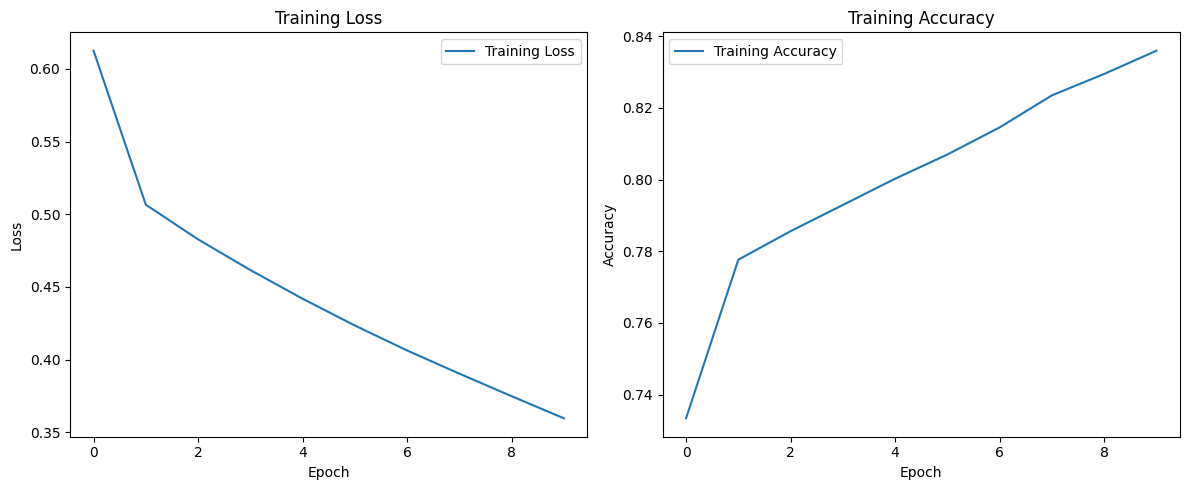

In [21]:
import matplotlib.pyplot as plt

# Set the sequence length to control memory usage
gemma_lm.preprocessor.sequence_length = CFG.sequence_length

# Compile the model with loss, optimizer, and metrics
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=8e-5),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train model and save the history
history = gemma_lm.fit(data, epochs=CFG.epochs, batch_size=CFG.batch_size)

# Plot accuracy and loss
def plot_training_history(history):
    # Create a figure for the plots
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to display plots
plot_training_history(history)


In [28]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
    Question=row.Question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=512)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
What are the symptoms of Cleft palate X-linked ?

**<font color='green'>Answer:</font>**
What are the signs and symptoms of Cleft palate X-linked? The Human Phenotype Ontology provides the following list of signs and symptoms for Cleft palate X-linked. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the palate 90% Abnormality of the teeth 90% Aplasia/Hypoplasia of the palate 90% Cognitive impairment 90% Feeding difficulties 90% Hearing impairment 90% Hyperactivity 90% Hyperreflexia 90% Hypertonia 90% Intellectual disability 90% Malabsorption 90% Muscular hypotonia 90% Seizures 90% Speech impairment 90% Abnormality of the palate - Abnormality of the teeth - Aplasia/Hypoplasia of the palate - Cognitive impairment - Hyperactivity - Hyperreflexia - Hypertonia - Intellectual disability - Speech impairment - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate of the percentage of patients who have that feature. The frequency may also be listed as a fraction. The first number of the fraction is how many people had the symptom, and the second number is the total number of people who were examined in one study. For example, a frequency of 25/25 means that in a study of 25 people all patients were found to have that symptom. Because these frequencies are based on a specific study, the fractions may be different if another group of patients are examined. Sometimes, no information on frequency is available. In these cases, the sign or symptom may be rare or common.

In [29]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
    Question=row.Question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=512)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
What are the treatments for Cri du chat syndrome ?

**<font color='green'>Answer:</font>**
How might Cri du chat syndrome be treated? Treatment of Cri du chat syndrome is directed toward the specific symptoms that the child is experiencing. For example, if a child has difficulty swallowing, treatment may include a special diet, special foods, or a feeding tube. If a child has difficulty speaking, treatment may include speech therapy. If a child has difficulty with motor skills, such as walking or using his or her hands, treatment may include physical therapy. If a child has seizures, treatment may include medication. If a child has a heart murmur, treatment may include surgery.

In [30]:
# Generate Prompt using template
prompt = template.format(
    Question="How is Lisinopril typically used?",
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=512)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
How is Lisinopril typically used?

**<font color='green'>Answer:</font>**
Lisinopril is used to lower blood pressure and treat high blood pressure (hypertension).

In [31]:
# Generate Prompt using template
prompt = template.format(
    Question="what is the usage of paracetamol?",
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=512)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
what is the usage of paracetamol?

**<font color='green'>Answer:</font>**
Paracetamol is a pain reliever and fever reducer that is used to relieve pain by decreasing fever. It is available in different doses and strengths, and can be taken by adults and children.

In [32]:
gemma_lm.save_to_preset("./gemma-medic-bot-2b-en")

In [33]:
import huggingface_hub

# Directly use your Hugging Face token here (replace "your_huggingface_token" with your actual token)
huggingface_hub.login(token="*****************")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [34]:
#hf_username = "EmmaGozie"
#model_variant_name = "gemma-medic-bot-2b-en"

#uri = f"hf://{hf_username}/{model_variant_name}"
#print(uri)

hf://EmmaGozie/gemma-medic-bot-2b-en


In [39]:
hf_uri = "hf://EmmaGozie/gemma-medic-bot-2b-en"

In [40]:
keras_nlp.upload_preset(hf_uri, './gemma-medic-bot-2b-en')

model.weights.h5:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

vocabulary.spm:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]